# Using vector data

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png"/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg"/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg"/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png"/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg"/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png"/>
</div>

This notebook shows how to use vector data for querying and for masking the data, limiting only to selected polygons. The shapefile is located in `./Supplementary_data/shapefiles/Betrieb_H.shp`

**NOTE:** It is necessary to install geopandas in the datacube environment and upload the shapefiles to a folder called `shapefiles` which should be located in the same folder where the notebook is uploaded. 

To install geopandas open a New Launcher (denoted by the + icon in the top left of the app, under the Edit menu) and select Terminal at the bottom.

In the Terminal you need to run two commands:
```shell
source activate datacube
conda install -y geopandas
```

The installation may take some time, but after finishing the Terminal may be closed.

In [2]:
import geopandas
import datacube
from datacube import helpers
from datacube.utils import geometry
import fiona
import rasterio.features
import xarray
import matplotlib.pyplot as plt
import matplotlib

In [17]:
matplotlib.rc('font', size=15)

## Load Polygons

The function `load_polygon` extracts geopolygon for usage in the `datacube` query and pfeature which is used by `rasterio` for the mask.

In [4]:
def load_polygon(shape_file):
    with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        return geometry.Geometry(first_geometry, crs=crs), geopandas.read_file(shape_file)

In [5]:
geopolygon_h, pfeature_h = load_polygon('./Supplementary_data/shapefiles/Betrieb_H.shp')

## Load ACube

In [6]:
acube = datacube.Datacube(app='sample_4')

## Define the query for desired polygon

The example shows polygon H being used. For using different geopolygons modify the code below

In [7]:
polygon = geopolygon_h
masking_feature = pfeature_h['geometry']
filename = 'LAI_POLYGON_M'
query = {
    'time': ('2017-03-01', '2017-10-31'),
    'product': 'LAI_Sentinel_2',
    'geopolygon': polygon,
    'output_crs': 'EPSG:32633',
    'resolution': (-10, 10)
}

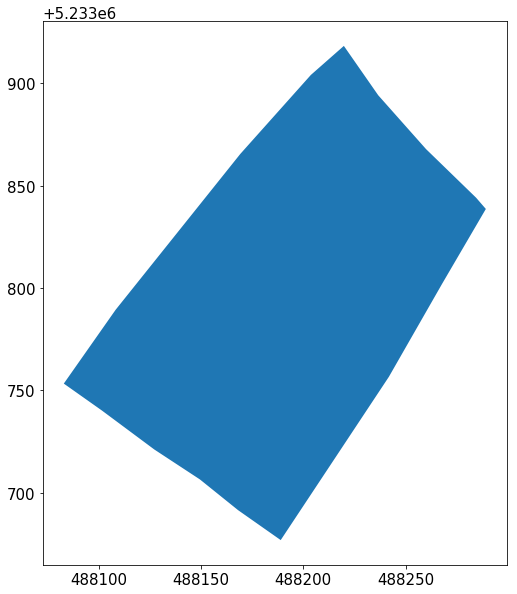

In [18]:
masking_feature.plot(figsize=(10, 10))

## Load Data

The following load function uses the defined geopolygon for querying, meaning the shapefile will be used for the query instead of the `lat` and `lon`.

In [9]:
data = acube.load(**query)
data

## Visualize Data

We can use `rasterio` to create a mask to mask out all the data outside of the polygon.

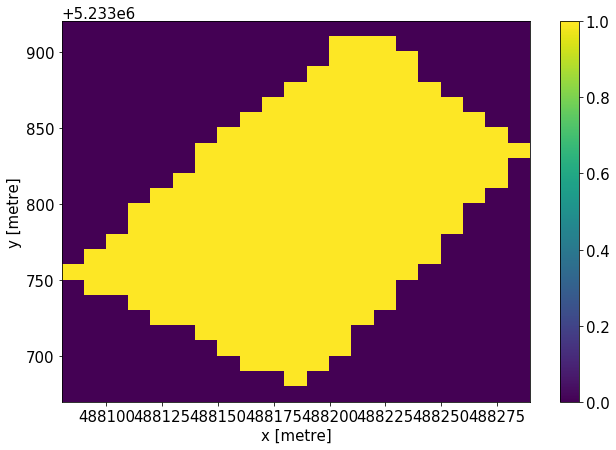

In [19]:
data_plot = data.band_1.where(data.band_1 != data.band_1.attrs['nodata']).dropna(dim='time')
mask = rasterio.features.rasterize(masking_feature,
                                   out_shape=data.isel(time=0).band_1.shape,
                                   transform=data.band_1.affine)
mask = xarray.DataArray(mask, coords=(data.y, data.x))
mask.plot(size=7)

The code for plotting below can be modified to display a different scale of values with the parameters `vmax` and `vmin`

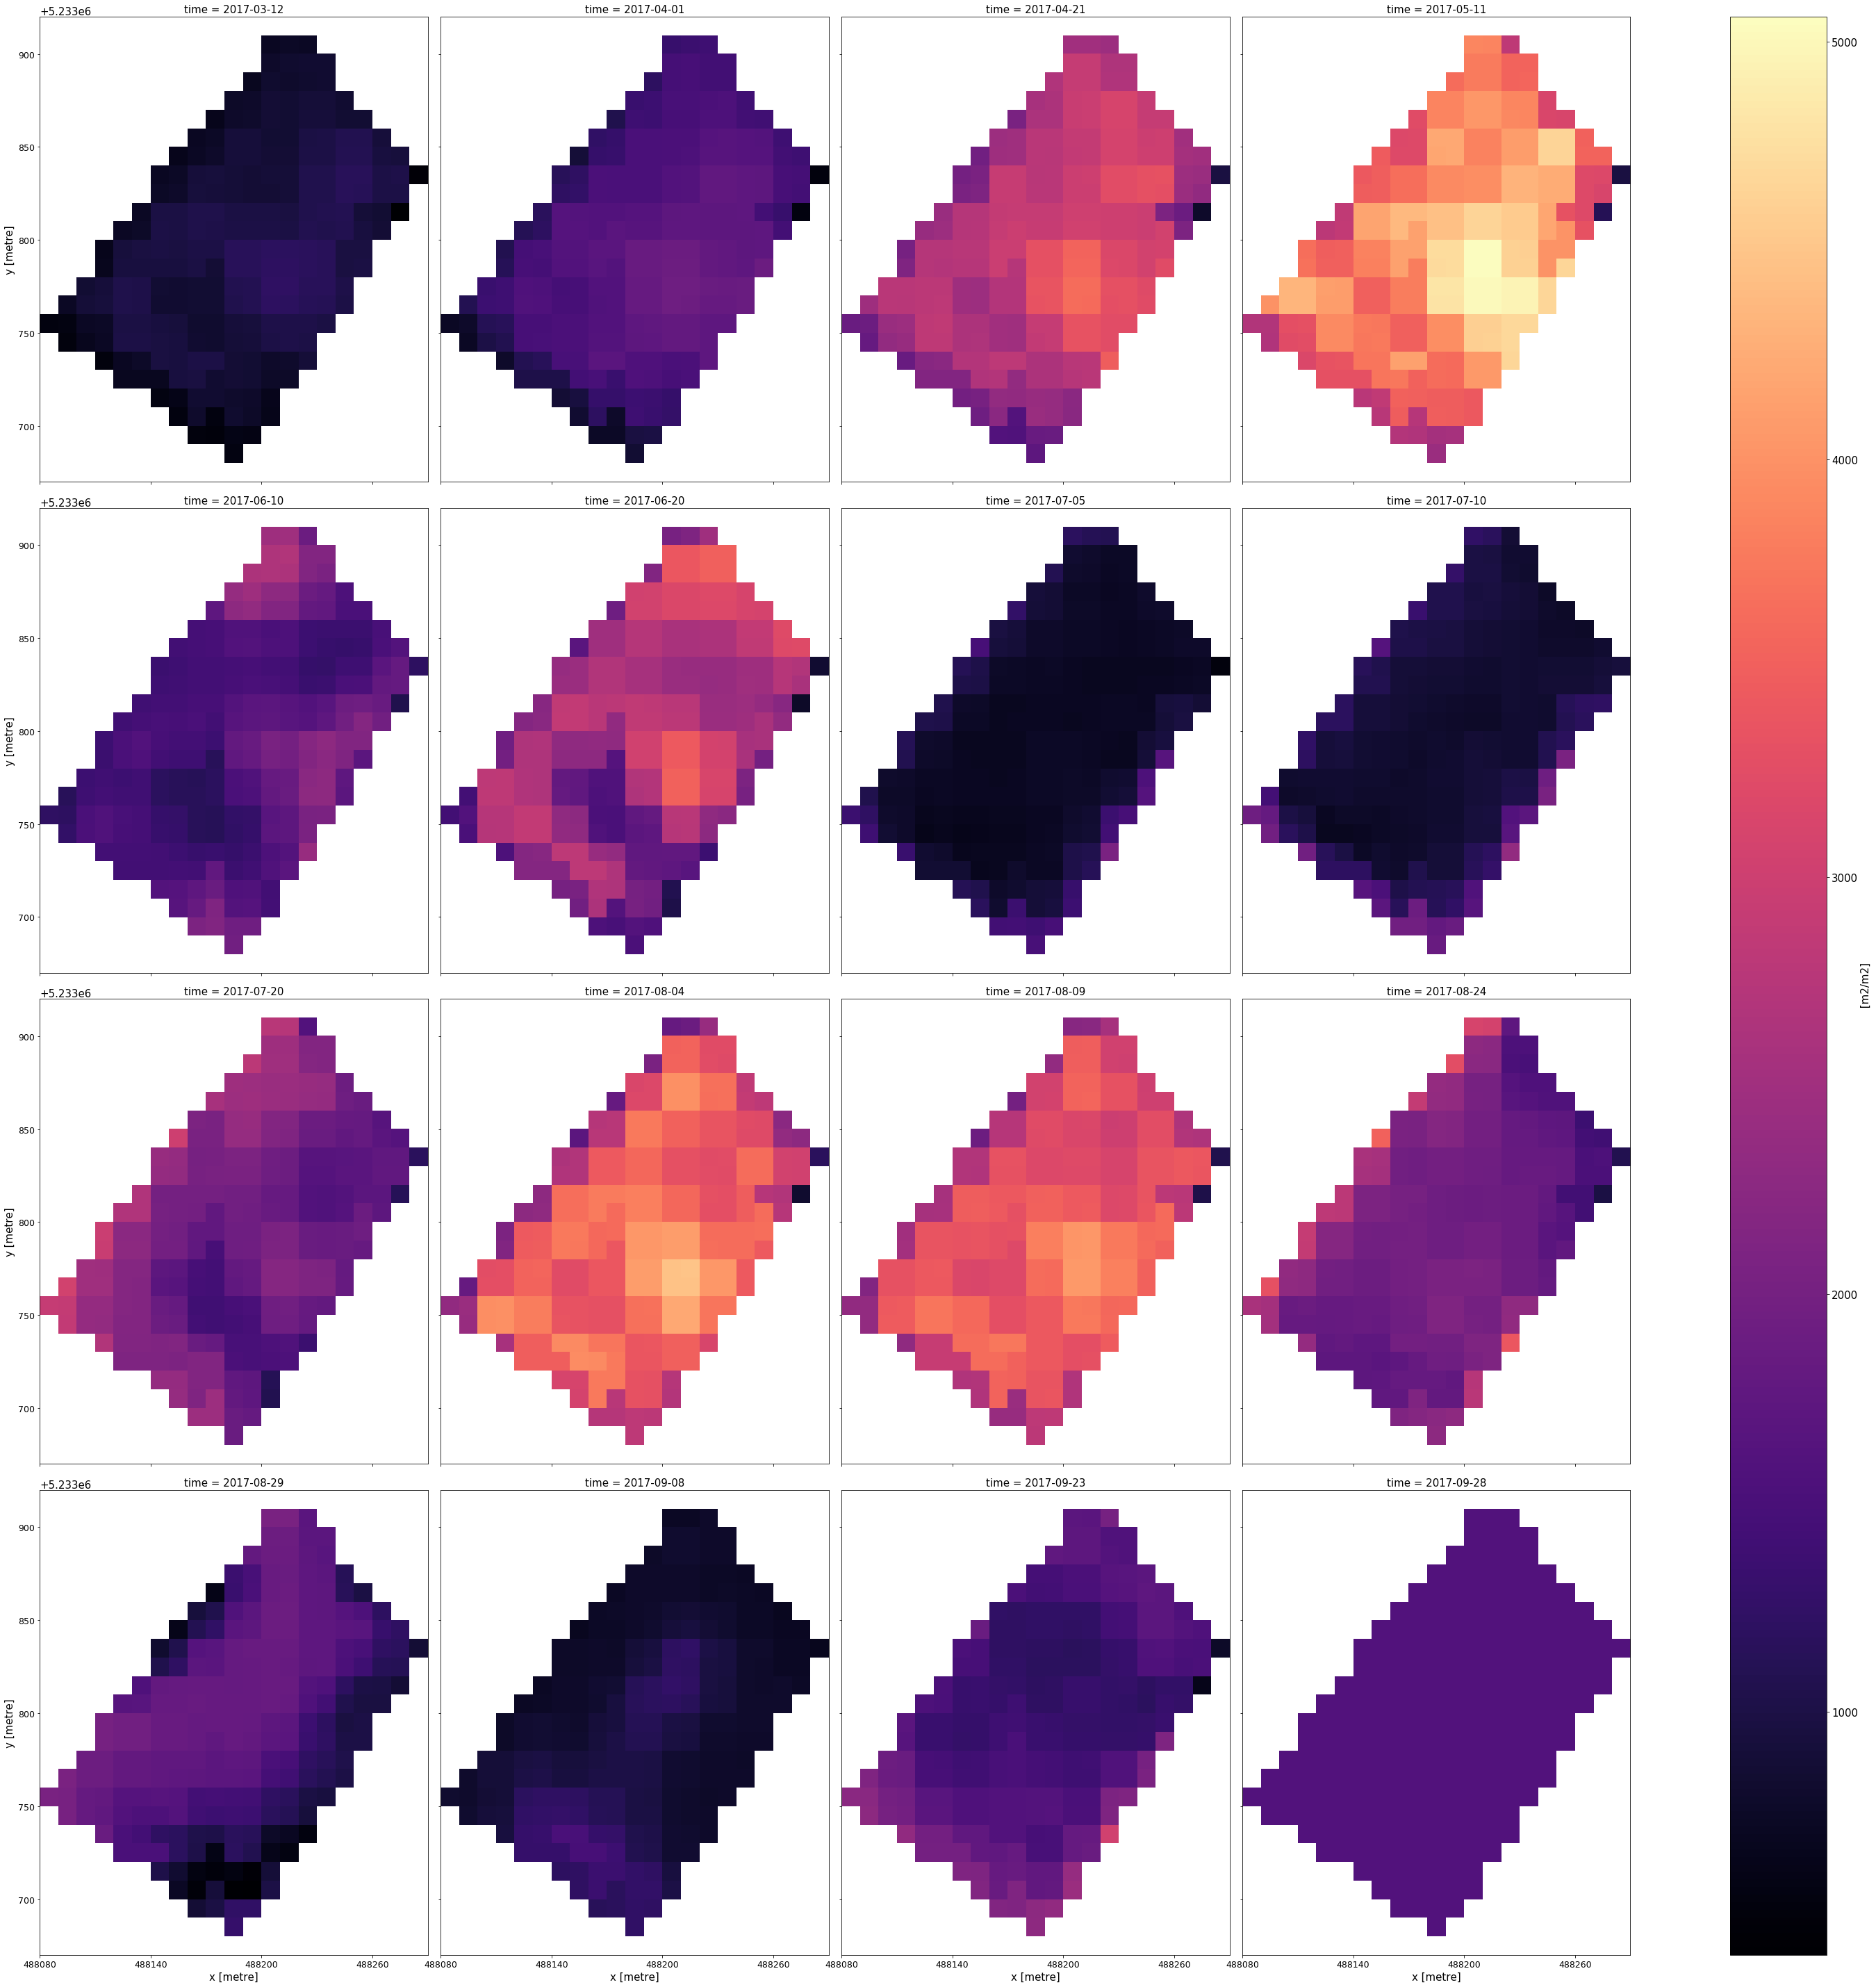

In [20]:
masked_data = data_plot.where(mask)
imshowfig = masked_data.plot.imshow(x=data_plot.crs.dimensions[1], 
                        y=data_plot.crs.dimensions[0],
                        col='time',
                        size=10,
                        col_wrap=4,
                        cmap='magma',
                        add_colorbar=True)#, vmax=3534, vmin=746)
imshowfig.set_ticks(max_xticks=4)

## Save and download data

The following code saves the data to the folder of the notebook. To download the data right click on the files and select Download.

In [29]:
download_data = masked_data.to_dataset(dim='band_1')
download_data = download_data.assign_attrs(crs=masked_data.crs)
for i in range(len(download_data.time)):
    date = str(download_data.isel(time=i).time.data)[:-19] # Without time
    filename2='{}_{}.tif'.format(filename, date)
    print('Saved: ', filename2)
    datacube.helpers.write_geotiff('export/' + filename2, download_data.isel(time=i))

Saved:  2017-04-01
Saved:  2017-05-11
Saved:  2017-06-10
Saved:  2017-06-20
Saved:  2017-07-05
Saved:  2017-07-10
Saved:  2017-07-20
Saved:  2017-08-04
Saved:  2017-08-09
Saved:  2017-08-24
Saved:  2017-08-29
Saved:  2017-09-23
Saved:  2017-09-28


/opt/conda/envs/datacube/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  """Entry point for launching an IPython kernel.
